In [2]:
import argparse
import os
import random
import shutil
import time
import warnings
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision
import torch.optim.lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

In [3]:
BATCH_SIZE = 20
EPOCH = 50
GAMMA = 0.9
STEP_SIZE = 200
LR = 0.001
USE_GPU = True
decoder = ['cliff', 'end', 'four', 'straight']
data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
img_path = '/media/arg_ws3/5E703E3A703E18EB/data/subt_laser'
model_path = './model'

In [4]:
alexnet = torchvision.models.alexnet(pretrained = True)
alexnet.classifier[6] = nn.Linear(4096, 4)
if USE_GPU:
    alexnet = alexnet.cuda()
#optimizer = torch.optim.Adam(alexnet.parameters(), lr=LR)   # optimize all cnn parameters
optimizer = torch.optim.SGD(alexnet.parameters(), lr = LR, momentum=0.9)
loss_func = nn.CrossEntropyLoss() # the target label is not one-hotted
if USE_GPU:
    loss_func = loss_func.cuda()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [16]:
class AlexNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(AlexNet, self).__init__()
        # Everything except the last linear layer
        self.base_features = base_model.features
        self.base_classifier = nn.Sequential(*base_model.classifier[:-1])
        self.new_classifier = nn.Sequential(
            nn.Linear(4096, num_classes)
        )
        self.modelName = 'MultiViewNet'
        
        '''
        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False
        '''

    def forward(self, img):
        f = self.base_features(img)
        f = f.view(f.size(0), -1)
        fc2 = self.base_classifier(f)
        y = self.new_classifier(fc2)
        return y

base_model = torchvision.models.alexnet(pretrained = True)
alexnet = AlexNet(base_model, 4)
if USE_GPU:
    alexnet = alexnet.cuda()
#for p in multiviewnet.base_features[0].parameters():
#    print(p.name, p.data)
#optimizer = torch.optim.Adam(alexnet.parameters(), lr=LR)   # optimize all cnn parameters
optimizer = torch.optim.SGD(alexnet.parameters(), lr = LR, momentum=0.9)
loss_func = nn.CrossEntropyLoss() # the target label is not one-hotted
if USE_GPU:
    loss_func = loss_func.cuda()
print(alexnet)

AlexNet(
  (base_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (base_classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, o

In [17]:
class laserDataset(torch.utils.data.Dataset):
    def __init__(self, root = '/media/arg_ws3/5E703E3A703E18EB/data/subt_laser', transform = None):
        self.root = root
        self.transform = transform
        self.imgData = datasets.ImageFolder(root = self.root, \
                                transform = self.transform)
        self.classes = self.imgData.classes
        self.class_to_idx = self.imgData.class_to_idx
        
    def __len__(self):
        return self.imgData.__len__()

    def __getitem__(self, idx):
        img = self.imgData.__getitem__(idx)[0]
        label = self.imgData.__getitem__(idx)[1]
        return img, label

In [18]:
class MultiViewScaleDataset(torch.utils.data.Dataset):
    def __init__(self, root = '../images', transform = None):
        self.root = root
        self.transform = transform
        self.imgData = datasets.ImageFolder(root = self.root, \
                                transform = self.transform)
        self.classes = self.imgData.classes
        self.class_to_idx = self.imgData.class_to_idx
        
    def __len__(self):
        return self.imgData.__len__()

    def __getitem__(self, idx):
        img = self.imgData.__getitem__(idx)[0]
        label = self.imgData.__getitem__(idx)[1]
        img_name = self.imgData.samples[idx][0]
        s = img_name.split('.jpg')
        s = s[0].split('/')
        scalar_nums = s[-1].split('_')[-3:]
        scalar_nums = [torch.FloatTensor([math.log(float(i))*2]) for i in scalar_nums]
        if len(scalar_nums)!=3:
            return img, label, ['0', '0', '0']
        return img, label, scalar_nums

# Loading data

### Use torch ImageFolder

In [19]:
'''train_data = datasets.ImageFolder(root = img_path, \
                                transform = data_transform)'''

'''train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                batch_size = BATCH_SIZE, \
                                shuffle = True)'''

'train_loader = torch.utils.data.DataLoader(dataset = train_data,                                 batch_size = BATCH_SIZE,                                 shuffle = True)'

### Use custom dataset

In [20]:
laserDst = laserDataset(root = img_path,\
                            transform = data_transform)
decoder = laserDst.classes
print(decoder)

['cliff', 'end', 'four', 'straight']


### Splitting dataset to training & validation set

In [22]:
dataset_size = len(laserDst) #3080 #2080
indices = list(range(dataset_size))
validation_split = .1
split = int(np.floor(validation_split * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset = laserDst, \
                                batch_size = BATCH_SIZE, \
                                sampler = train_sampler)
train_size = len(train_indices)
validation_size = len(val_indices)
validation_loader = torch.utils.data.DataLoader(dataset = laserDst, \
                                batch_size = validation_size, \
                                sampler = valid_sampler)
valid_iter = iter(validation_loader)
valid_data = next(valid_iter)
valid_y = valid_data[1].cuda()
print('Dataset size:', dataset_size)
print('train size:', train_size)
print('validation size:', validation_size)

Dataset size: 1451
train size: 1306
validation size: 145


In [23]:
def compute_accuracy_scale(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
        scale = [x.cuda() for x in validset[2]]
    output = model(validset[0], scale)
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

In [24]:
def compute_accuracy(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
    output = model(validset[0])
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

Epoch:  0 | train loss: 0.026315 | accuracy: 0.9724 | learning rate: 0.001000
Epoch:  1 | train loss: 0.034559 | accuracy: 0.9586 | learning rate: 0.001000
Epoch:  2 | train loss: 0.002538 | accuracy: 0.9724 | learning rate: 0.001000
Epoch:  3 | train loss: 0.009349 | accuracy: 0.9862 | learning rate: 0.001000


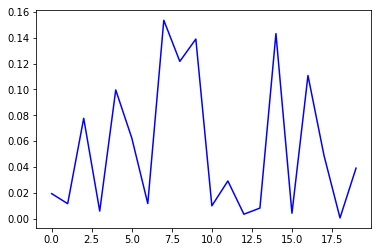

Epoch:  4 | train loss: 0.004727 | accuracy: 0.9862 | learning rate: 0.000900
Epoch:  5 | train loss: 0.001077 | accuracy: 0.9931 | learning rate: 0.000900
Save net:  ./model/epoch5.pth
Epoch:  6 | train loss: 0.001486 | accuracy: 0.9931 | learning rate: 0.000900


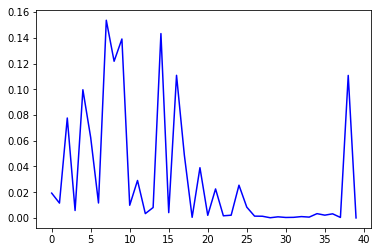

Epoch:  7 | train loss: 0.000276 | accuracy: 0.9931 | learning rate: 0.000810
Epoch:  8 | train loss: 0.000022 | accuracy: 0.9931 | learning rate: 0.000810
Epoch:  9 | train loss: 0.000101 | accuracy: 0.9931 | learning rate: 0.000810


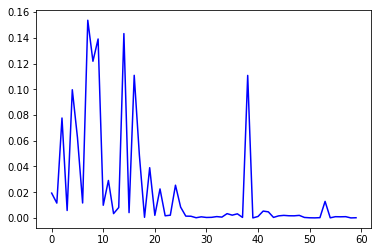

Epoch:  10 | train loss: 0.001351 | accuracy: 1.0000 | learning rate: 0.000729
Save net:  ./model/epoch10.pth
Epoch:  11 | train loss: 0.000221 | accuracy: 0.9931 | learning rate: 0.000729
Epoch:  12 | train loss: 0.000116 | accuracy: 0.9931 | learning rate: 0.000729


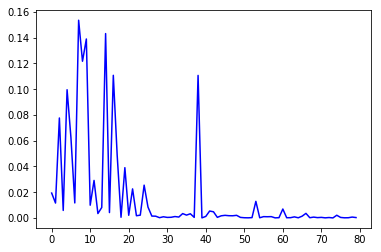

Epoch:  13 | train loss: 0.000282 | accuracy: 0.9931 | learning rate: 0.000656
Epoch:  14 | train loss: 0.000064 | accuracy: 0.9931 | learning rate: 0.000656
Epoch:  15 | train loss: 0.001220 | accuracy: 0.9931 | learning rate: 0.000656


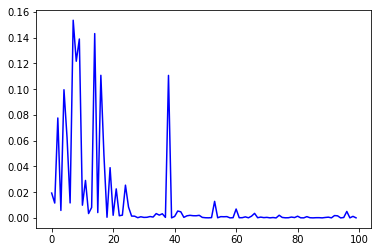

Save net:  ./model/epoch15.pth
Epoch:  16 | train loss: 0.000332 | accuracy: 1.0000 | learning rate: 0.000590
Epoch:  17 | train loss: 0.000100 | accuracy: 0.9931 | learning rate: 0.000590
Epoch:  18 | train loss: 0.000223 | accuracy: 0.9931 | learning rate: 0.000590


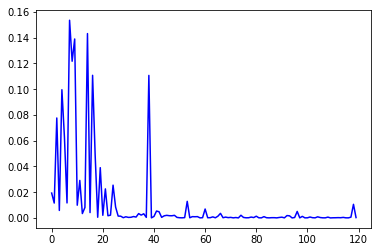

Epoch:  19 | train loss: 0.000431 | accuracy: 0.9931 | learning rate: 0.000531
Epoch:  20 | train loss: 0.001059 | accuracy: 0.9931 | learning rate: 0.000531
Save net:  ./model/epoch20.pth
Epoch:  21 | train loss: 0.000038 | accuracy: 0.9931 | learning rate: 0.000531


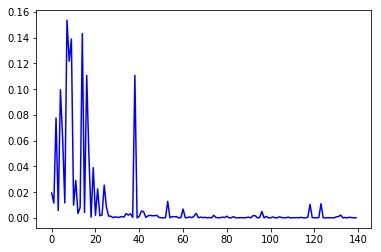

Epoch:  22 | train loss: 0.000055 | accuracy: 0.9931 | learning rate: 0.000478
Epoch:  23 | train loss: 0.000039 | accuracy: 1.0000 | learning rate: 0.000478
Epoch:  24 | train loss: 0.000014 | accuracy: 0.9931 | learning rate: 0.000478


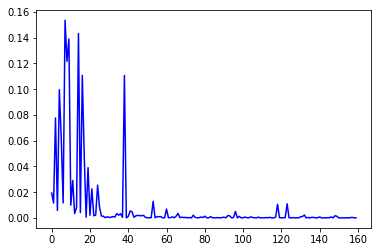

Epoch:  25 | train loss: 0.000018 | accuracy: 0.9931 | learning rate: 0.000430
Save net:  ./model/epoch25.pth
Epoch:  26 | train loss: 0.000023 | accuracy: 0.9862 | learning rate: 0.000430
Epoch:  27 | train loss: 0.000483 | accuracy: 0.9931 | learning rate: 0.000430


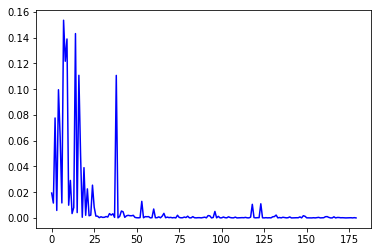

Epoch:  28 | train loss: 0.000026 | accuracy: 0.9931 | learning rate: 0.000387
Epoch:  29 | train loss: 0.000075 | accuracy: 0.9931 | learning rate: 0.000387
Epoch:  30 | train loss: 0.000009 | accuracy: 0.9931 | learning rate: 0.000387


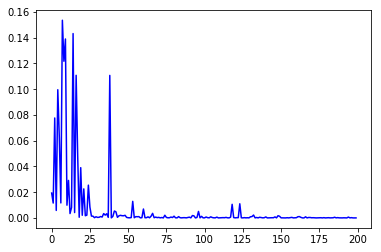

Save net:  ./model/epoch30.pth
Epoch:  31 | train loss: 0.000037 | accuracy: 1.0000 | learning rate: 0.000349
Epoch:  32 | train loss: 0.000056 | accuracy: 1.0000 | learning rate: 0.000349
Epoch:  33 | train loss: 0.000038 | accuracy: 0.9931 | learning rate: 0.000349


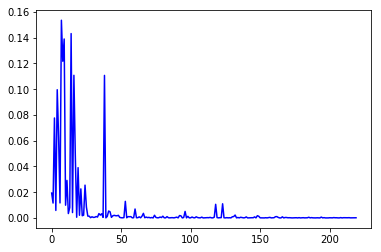

Epoch:  34 | train loss: 0.000072 | accuracy: 0.9931 | learning rate: 0.000314
Epoch:  35 | train loss: 0.000092 | accuracy: 0.9931 | learning rate: 0.000314
Save net:  ./model/epoch35.pth
Epoch:  36 | train loss: 0.000014 | accuracy: 0.9931 | learning rate: 0.000314


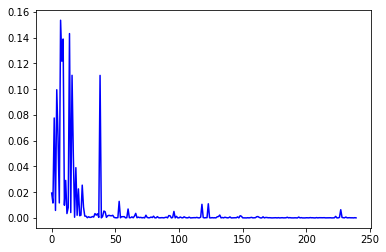

Epoch:  37 | train loss: 0.000006 | accuracy: 0.9931 | learning rate: 0.000282
Epoch:  38 | train loss: 0.000035 | accuracy: 0.9931 | learning rate: 0.000282
Epoch:  39 | train loss: 0.000084 | accuracy: 0.9931 | learning rate: 0.000282


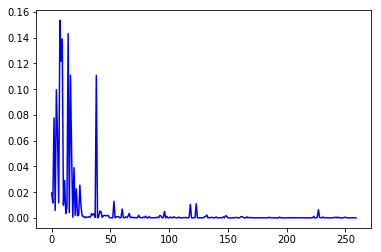

Epoch:  40 | train loss: 0.000002 | accuracy: 1.0000 | learning rate: 0.000254
Save net:  ./model/epoch40.pth
Epoch:  41 | train loss: 0.000084 | accuracy: 1.0000 | learning rate: 0.000254
Epoch:  42 | train loss: 0.000086 | accuracy: 0.9931 | learning rate: 0.000254


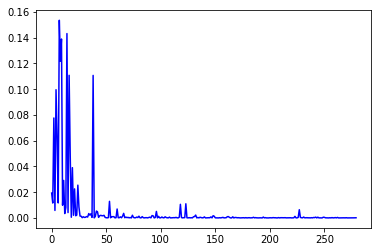

Epoch:  43 | train loss: 0.000029 | accuracy: 0.9931 | learning rate: 0.000229
Epoch:  44 | train loss: 0.000224 | accuracy: 0.9931 | learning rate: 0.000229
Epoch:  45 | train loss: 0.000040 | accuracy: 0.9931 | learning rate: 0.000229


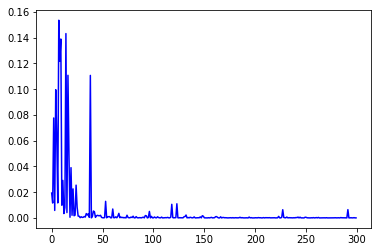

Save net:  ./model/epoch45.pth
Epoch:  46 | train loss: 0.000121 | accuracy: 0.9931 | learning rate: 0.000206
Epoch:  47 | train loss: 0.000551 | accuracy: 1.0000 | learning rate: 0.000206
Epoch:  48 | train loss: 0.000147 | accuracy: 0.9931 | learning rate: 0.000206


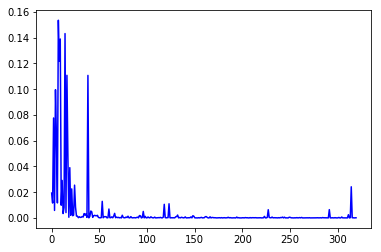

Epoch:  49 | train loss: 0.001208 | accuracy: 0.9931 | learning rate: 0.000185
Finish


In [27]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
count = 0
loss_values = []
lr = LR
for epoch in range(EPOCH):
    #for step, (b_x, b_y, b_scale) in enumerate(train_loader):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        if USE_GPU:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            
        '''if USE_GPU:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            b_scale = [x.cuda() for x in b_scale]'''
        
        #output = multiviewnet(b_x, b_scale)  # cnn output
        output = alexnet(b_x)  # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        #scheduler.step()                # dynamic learning rate
        
        if count % STEP_SIZE == 0 and count != 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= GAMMA
                lr = param_group['lr']
        
        if step % 100 == 0:
            #accuracy = compute_accuracy_scale(multiviewnet, valid_data, valid_y)
            accuracy = compute_accuracy(alexnet, valid_data, valid_y)
            print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), \
                  '| accuracy: %.4f' % accuracy, \
                  '| learning rate: %.6f' % lr)
        if count % 10 == 0 and count != 0:
            loss_values.append(loss.item())
        if count % 200 == 0 and count != 0:
            plt.plot(loss_values, '-b', label='loss')
            plt.show()
        count = count + 1
    if epoch % 5 == 0 and epoch != 0:
        PATH = model_path + '/epoch' + str(epoch) + '.pth'
        #torch.save(multiviewnet.state_dict(), PATH)
        torch.save(alexnet.state_dict(), PATH)
        print("Save net: ", PATH)
print("Finish")

In [ ]:
alexnet.load_state_dict(torch.load('../model/robotx_ch3_epoch25.pth'))
alexnet.eval()
#alexnet = torch.load('./robotx_ch3.pth')
#alexnet.eval()

In [34]:
show_loader = torch.utils.data.DataLoader(dataset = laserDst, \
                                batch_size = 1, \
                                sampler = valid_sampler)
show_iter = iter(show_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 227, 227])
torch.Size([1, 6, 227, 227])
Prediction:  four
Label:  four
Image shape:  (227, 227, 3)


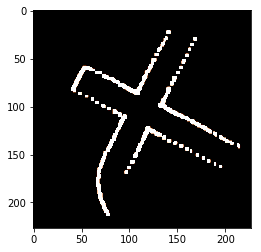

In [54]:
data = next(show_iter)
img = data[0][0].numpy()
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
output = alexnet(x)
print(x.shape)
print(x.repeat(1, 2, 1, 1).shape)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

In [33]:
data = next(show_iter)
img = data[0][0].numpy()
print(img.shape)
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
print(x.shape)
scalar_data = [i.cuda() for i in data[2]]
output = multiviewnet(x, scalar_data)
print(scalar_data)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

TypeError: 'type' object is not subscriptable

In [96]:
torch.save(multiviewnet, '../model_scale/robotx_final.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MultiViewNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
